In [1]:
# Import the pySIFT code.
import sys
sys.path.append("pySift")
from pySift import sift, matching

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

import time
from collections import Counter
import pylab as plt
from IPython import display
import pickle
from pandas.tools.plotting import scatter_matrix
import pandas as pd
import random
import itertools
from sys import getsizeof

from sklearn.neighbors import *
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.svm import *

from sklearn.gaussian_process import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.ensemble import *

from sklearn.linear_model import SGDClassifier
from sklearn.cluster import *

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import *
from sklearn import preprocessing
from sklearn.metrics import *

In [27]:
class_names = ["Blue Whale", "Chiuaua", "Chimpanzee", "Fox","Gorilla", "Killer Whale", "Seal", "Tiger", "Wolf", "Zebra"]

trainimages = [line.strip().split(" ")[0] for line in open("trainset-overview.txt", "r")]
train_labels = np.array([int(line.strip().split(" ")[1]) for line in open("trainset-overview.txt", "r")])

valimages = [line.split(' ')[0] for line in open('valset-overview.txt','r')]
val_labels = np.array([int(line.rstrip().split(' ')[1]) for line in open('valset-overview.txt','r')])

testimages = [line.strip().split(' ')[0] for line in open('testset-overview-final.txt','r')]

def siftPointsPerImage(images, densepoints=True, hespoints=True, harpoints=True, sigma=1.0):
    """List of imagepaths in in, list of points per images out"""
    siftPointsPerImage = []
    for i in xrange(len(images)):
        densepoints = sift.densePoints(images[i], stride=25)
        hespoints   = sift.computeHes(images[i], sigma, magThreshold=15, hesThreshold=10, NMSneighborhood=10)
        harpoints   = sift.computeHar(images[i], sigma, magThreshold=5, NMSneighborhood=10)
        allpoints = np.concatenate((densepoints, hespoints, harpoints))
        point, siftpoints = sift.computeSIFTofPoints(images[i], allpoints, sigma, nrOrientBins=8, nrSpatBins=4, nrPixPerBin=4)
        siftPointsPerImage.append(siftpoints)
    return np.array(siftPointsPerImage)

def calculateHistograms(imagePointCollections, nr_clusters, clusters):
    '''Calculates the histogram per image by the trainingpoints of the image.'''
    n_images = len(imagePointCollections)
    histograms = np.zeros((n_images, nr_clusters))
    for i in xrange(n_images):
        siftpoints = imagePointCollections[i]
        distribution = clusters.predict(siftpoints)
        hist = np.histogram(distribution, bins=range(nr_clusters+1))
        histograms[i] = hist[0]
    return histograms

def plot_confusion_matrix(val_labels, val_predictions):
    """Plot a confusion matrix"""
    cm = confusion_matrix(val_labels, val_predictions)
    
    tick_marks = np.arange(len(class_names))
    plt.figure(figsize=(10,10))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.show()
    
def bestVotedPredictions(predictionArray):
    """Input array with predictions per classifier, count votes each prediction gets return list most voted predictions."""
    alld = np.stack(predictionArray, axis=0)
    newPredictions = []
    for i in alld.T:
        counts = np.bincount(i)
        print "counts", counts
        newPredictions.append(np.argmax(counts))
        print "argmax", np.argmax(counts)
    return newPredictions

def bestPredictionsPerSpecies(predictionArray, labels, classifiers):
    number_of_species = len(np.unique(labels))
    correct_classified = np.zeros((len(classifiers),number_of_species))
        
    for i, predictions_of_classifier in enumerate(predictionArray):
        m = confusion_matrix(labels, predictions_of_classifier)
        for j in range(0, number_of_species):
            correct_classified[i][j] = m[j][j]
        
    return correct_classified

In [3]:
trainpoints = np.load('trainingset_SiftPointsPerImage.npy')
valpoints = np.load('validationset_SiftPointsPerImage.npy')
testpoints = np.load('testset_SiftPointsPerImage.npy')

In [5]:
# PIK = "clusters/300/MiniBatchKMeans_K300_maxiter300_original_5.dat"

k = 6000
itr = 300
org = 3
PIK = "clusters/6000/MiniBatchKMeans_K"+str(k)+"_maxiter"+str(itr)+"_original_"+str(org)+".dat"

with open(PIK, "rb") as f:
    clusters = pickle.load(f)
nr_clusters = clusters.n_clusters

In [6]:
train_feat = calculateHistograms(trainpoints, nr_clusters, clusters)
val_feat = calculateHistograms(valpoints, nr_clusters, clusters)
test_feat = calculateHistograms(testpoints, nr_clusters, clusters)
del trainpoints
del valpoints
del testpoints
del clusters

train_feat_normalized = preprocessing.normalize(train_feat, norm='l2')
val_feat_normalized = preprocessing.normalize(val_feat, norm='l2')
test_feat_normalized = preprocessing.normalize(test_feat, norm='l2')

# One classifier

CPU times: user 12.9 s, sys: 86.5 ms, total: 13 s
Wall time: 13.2 s
[[13  0  1  1  0  1  3  0  1  0]
 [ 1  7  1  2  0  1  0  1  6  1]
 [ 0  3 11  0  3  0  0  2  1  0]
 [ 0  1  1  8  2  2  2  1  3  0]
 [ 0  2  1  6  4  0  2  1  4  0]
 [ 9  1  2  0  0  1  5  1  1  0]
 [ 3  1  3  4  0  1  5  1  2  0]
 [ 0  0  0  1  1  1  0 14  2  1]
 [ 0  1  3  4  0  0  0  2 10  0]
 [ 0  0  1  7  0  2  0  2  0  8]]
[13  0  1  1  0  1  3  0  1  0]
SVC nr_clusters: 6000
train accuracy: 0.543
validation accuracy: 0.405


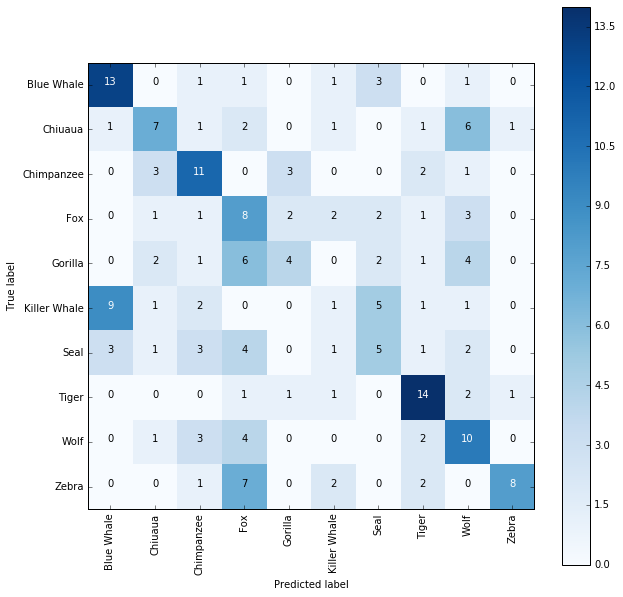

In [7]:
clf = SVC()
# clf.set_params(**SVC_params)

%time clf.fit(train_feat_normalized,train_labels)
train_predictions = clf.predict(train_feat_normalized)
train_accuracy = clf.score(train_feat_normalized, train_labels)

val_predictions = clf.predict(val_feat_normalized)
val_accuracy = clf.score(val_feat_normalized, val_labels)

print 30*'='

# print val_predictions
# print val_labels
print confusion_matrix(val_labels, val_predictions)
print confusion_matrix(val_labels, val_predictions)[0]

print clf.__class__.__name__,'nr_clusters:',nr_clusters
print 'train accuracy:',train_accuracy
print 'validation accuracy:',val_accuracy

plot_confusion_matrix(val_labels, val_predictions)

# Multiple classifiers

In [28]:
predictions = []
test_predictions = []
fscores = []

classifiers = [
    KNeighborsClassifier(n_neighbors=250, n_jobs=-1),
    SVC(kernel="linear", C=1),
    SVC(kernel="poly", C=1),
    SVC(kernel="rbf", C=1),
    GradientBoostingClassifier(),
    NuSVC(kernel='linear',probability=True),
    NuSVC(kernel='rbf',probability=True),
    NuSVC(kernel='poly',probability=True),
    LinearDiscriminantAnalysis(),
    SGDClassifier(n_jobs=-1),
    GaussianProcessClassifier(n_jobs=-1),
    DecisionTreeClassifier(max_depth=6),
    RandomForestClassifier(n_estimators=1000, n_jobs=-1),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    NearestCentroid()
    ]
        
for index, clf in enumerate(classifiers):
    name = clf.__class__.__name__
    
    clf.fit(train_feat_normalized, train_labels) 
    accuracy = clf.score(val_feat_normalized, val_labels)
    val_predictions = clf.predict(val_feat_normalized)
    
    if accuracy > 0.40:
        predictions.append(val_predictions)
        fscores.insert(index, f1_score(val_labels, val_predictions, average=None))
    
#     print(classification_report(val_labels, val_predictions, target_names=class_names))
#     plot_confusion_matrix(val_labels, val_predictions)
    print 'name:',name,'\n','accuracy:',accuracy,'\n',"="*30

val_predictions = bestVotedPredictions(predictions)
# plot_confusion_matrix(val_labels, val_predictions)
print(classification_report(val_labels, val_predictions, target_names=class_names))

accuracy = val_predictions == val_labels
print float(np.sum(accuracy))/len(accuracy)
print len(predictions)

name: KNeighborsClassifier 
accuracy: 0.355 
name: SVC 
accuracy: 0.485 
name: SVC 
accuracy: 0.325 
name: SVC 
accuracy: 0.405 
name: GradientBoostingClassifier 
accuracy: 0.4 
name: NuSVC 
accuracy: 0.48 
name: NuSVC 
accuracy: 0.445 
name: NuSVC 
accuracy: 0.315 
name: LinearDiscriminantAnalysis 
accuracy: 0.265 
name: SGDClassifier 
accuracy: 0.32 
name: GaussianProcessClassifier 
accuracy: 0.44 
name: DecisionTreeClassifier 
accuracy: 0.215 
name: RandomForestClassifier 
accuracy: 0.52 
name: MLPClassifier 
accuracy: 0.515 
name: AdaBoostClassifier 
accuracy: 0.23 
name: GaussianNB 
accuracy: 0.25 
name: NearestCentroid 
accuracy: 0.41 
counts [1 1 5 0 0 0 1]
argmax 2
counts [6 0 0 0 0 0 2]
argmax 0
counts [8]
argmax 0
counts [8]
argmax 0
counts [8]
argmax 0
counts [8]
argmax 0
counts [7 0 0 0 0 0 1]
argmax 0
counts [0 4 0 0 0 0 0 0 2 2]
argmax 1
counts [8]
argmax 0
counts [8]
argmax 0
counts [7 0 0 0 0 0 1]
argmax 0
counts [1 0 0 0 0 6 1]
argmax 5
counts [8]
argmax 0
counts [8]
a

## Checking highest scoring classifier per species in terms of f1 score

In [26]:
f1_per_species = np.zeros((len(class_names),len(classifiers)))
best_classifiers = []

for index_f1, clf_f1 in enumerate(fscores):
    for index_species_f1, species_f1 in enumerate(clf_f1):
        f1_per_species[index_species_f1][index_f1] = species_f1
    
# 3, 4, 5, 9, 11, 14, 15, 16 are not used?    
for i, species in enumerate(f1_per_species):
    print "--------------------------------------"
    print "Best Classifier for classifying the", class_names[i], "is number:", np.argmax(f1_per_species[i]), "being:"
    print classifiers[np.argmax(f1_per_species[i])]
    best_classifiers.append(classifiers[np.argmax(f1_per_species[i])])

--------------------------------------
Best Classifier for classifying the Blue Whale is number: 8 being:
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)
--------------------------------------
Best Classifier for classifying the Chiuaua is number: 7 being:
NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
   max_iter=-1, nu=0.5, probability=True, random_state=None,
   shrinking=True, tol=0.001, verbose=False)
--------------------------------------
Best Classifier for classifying the Chimpanzee is number: 2 being:
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
--------------------------------------
Best Classifier for classifying the Fox is number: 7 b

In [ ]:
# val_predictions2 = []
predictions2 = []

for index_species, clf in enumerate(best_classifiers):
    name = clf.__class__.__name__
    
    clf.fit(train_feat_normalized, train_labels) 
    accuracy = clf.score(val_feat_normalized, val_labels)
    val_predictions2 = clf.predict(val_feat_normalized)
    print np.where(val_predictions2 == index_species)[0]
    predictions2.append(val_predictions2)
    
#     print(classification_report(val_labels, val_predictions2, target_names=class_names))
#     plot_confusion_matrix(val_labels, val_predictions)
#     print 'name:',name,'\n','accuracy:',accuracy,'\n',"="*30
    
val_predictions2 = bestVotedPredictions(predictions2)
# plot_confusion_matrix(val_labels, val_predictions)
print(classification_report(val_labels, val_predictions2, target_names=class_names))

accuracy = val_predictions2 == val_labels
print float(np.sum(accuracy))/len(accuracy)
print len(predictions2)

In [21]:
from sklearn.metrics import classification_report
print(classification_report(val_labels, val_predictions, target_names=class_names))

# from sklearn.metrics import precision_recall_curve
# precision, recall, thresholds = precision_recall_curve(val_labels, val_predictions)

from sklearn.metrics import f1_score
print f1_score(val_labels, val_predictions, average=None)
print "-------------------------"
# precision_recall_fscore_support calculates all 3 of them and puts into seperate arrays.
from sklearn.metrics import precision_recall_fscore_support
print precision_recall_fscore_support(val_labels, val_predictions, average=None)[2]

              precision    recall  f1-score   support

  Blue Whale       0.86      0.30      0.44        20
     Chiuaua       0.44      0.20      0.28        20
  Chimpanzee       0.00      0.00      0.00        20
         Fox       0.21      0.45      0.29        20
     Gorilla       0.00      0.00      0.00        20
Killer Whale       0.29      0.90      0.44        20
        Seal       0.40      0.30      0.34        20
       Tiger       0.37      0.85      0.52        20
        Wolf       0.00      0.00      0.00        20
       Zebra       0.73      0.55      0.63        20

 avg / total       0.33      0.35      0.29       200

[ 0.44444444  0.27586207  0.          0.29032258  0.          0.43902439
  0.34285714  0.51515152  0.          0.62857143]
-------------------------
[ 0.44444444  0.27586207  0.          0.29032258  0.          0.43902439
  0.34285714  0.51515152  0.          0.62857143]


In [ ]:
# See which classifier gets above average results in correctly classifing a picture.
# These classifiers should have more influence on the resulting prediction than average or below average classifiers.
perSpecies = bestPredictionsPerSpecies(predictions, val_labels, classifiers)
print perSpecies.mean(0)

In [ ]:
from itertools import cycle

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# import some data to play with
iris = datasets.load_iris()
X = train_feat_normalized
y = train_labels
y = label_binarize(y, classes=[0, 1, 2])

print X.shape
print y.shape

In [ ]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
lw = 2

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=random_state)

# Run classifier
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")


# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"], color='gold', lw=lw,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()